Reading classics [Deep Learning Models](https://nbviewer.jupyter.org/github/rasbt/deeplearning-models/blob/master/pytorch_ipynb/autoencoder/ae-basic.ipynb)

## Code Modules, Functions, & Classes

In [ ]:
import numpy as np,pandas as pd,pylab as pl
import h5py,torch,urllib,zipfile
from torchvision.datasets import MNIST as tmnist
from torchvision import transforms,utils
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
import torch.nn.functional as tnnf
import torch.nn as tnn
import tensorflow.image as timage
dev=torch.device("cuda:0" \
if torch.cuda.is_available() else "cpu")

In [ ]:
class TData(tds):
    def __init__(self,x,y):   
        self.x=torch.tensor(x,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.int32)
    def __getitem__(self,index):
        img,lbl=self.x[index],self.y[index]
        return img,lbl
    def __len__(self):
        return self.y.shape[0]

In [ ]:
def display_examples(data_loader,img_size):
    for images,labels in data_loader:  
        print('Image dimensions: %s'%str(images.shape))
        print('Label dimensions: %s'%str(labels.shape))
        n=np.random.randint(1,50)
        fig=pl.figure(figsize=(10,4))
        for i in range(n,n+5):
            ax=fig.add_subplot(1,5,i-n+1,\
            xticks=[],yticks=[],title=labels[i].item())
            ax.imshow((images[i]).reshape(img_size,img_size),
                      cmap=pl.cm.bone)
        break
def display_results(num_images):
    num_images=int(num_images)
    fig,axes=pl.subplots(nrows=2,ncols=num_images, 
                         sharex=True,sharey=True,
                         figsize=(10,4))
    original_images=features[:num_images]
    decoded_images=decoded[:num_images]
    for i in range(num_images):
        for ax,img in zip(axes,[original_images,
                                decoded_images]):
            curr_img=img[i].detach().to(torch.device('cpu'))
            ax[i].imshow(curr_img.view((img_size,img_size)),
                         cmap='bone')
    pl.show()

## Data

In [ ]:
random_seed=12; batch_size=128; img_size=32
trans=transforms\
.Compose([transforms.Resize((img_size,img_size)),
          transforms.ToTensor()])
train=tmnist(root='data',train=True,
             download=True,transform=trans)
test=tmnist(root='data',train=False, 
            transform=trans)
train_loader=tdl(dataset=train,shuffle=True, 
                 batch_size=batch_size)
test_loader=tdl(dataset=test,shuffle=False, 
                batch_size=batch_size)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Image dimensions: torch.Size([128, 1, 32, 32])
Label dimensions: torch.Size([128])


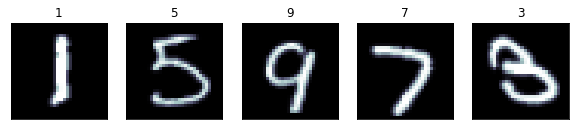

In [ ]:
display_examples(test_loader,img_size)

In [ ]:
fpath='https://olgabelitskaya.github.io/'
zf='LetterColorImages_123.h5.zip'
input_file=urllib.request.urlopen(fpath+zf)
output_file=open(zf,'wb'); 
output_file.write(input_file.read())
output_file.close(); input_file.close()
zipf=zipfile.ZipFile(zf,'r')
zipf.extractall(''); zipf.close()
f=h5py.File(zf[:-4],'r')
keys=list(f.keys()); print(keys)
x=1-np.array(f[keys[1]],dtype='float32')/255
x=timage.resize(x,[img_size,img_size])
x=(np.dot(x.numpy(),[.299,.587,.114]))\
.reshape(-1,1,img_size,img_size)
y=np.array(f[keys[2]],dtype='int32')-1
N=y.shape[0]; n=int(.2*N)
shuffle_ids=np.arange(N)
np.random.RandomState(23).shuffle(shuffle_ids)
x,y=x[shuffle_ids],y[shuffle_ids]
x_test,x_train=x[:n],x[n:]
y_test,y_train=y[:n],y[n:]

['backgrounds', 'images', 'labels']


In [ ]:
random_seed=23; batch_size2=128
train2=TData(x_train,y_train)
test2=TData(x_test,y_test)
train_loader2=tdl(dataset=train2,shuffle=True,
                  batch_size=batch_size2)
test_loader2=tdl(dataset=test2,shuffle=False,
                 batch_size=batch_size2)

Image dimensions: torch.Size([128, 1, 32, 32])
Label dimensions: torch.Size([128])


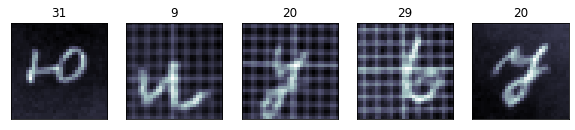

In [ ]:
display_examples(test_loader2,img_size)

## Autoencoder
compresses 32x32-pixel images into (hidden1)-pixel vectors & restores the original images

In [ ]:
class AE(tnn.Module):
    def __init__(self,num_features,hidden1):
        super(AE,self).__init__()
        # encoder
        self.linear1=tnn.Linear(num_features,hidden1)
        self.linear1.weight.detach().normal_(0.,.1)
        self.linear1.bias.detach().zero_()
        # decoder
        self.linear2=tnn.Linear(hidden1,num_features)
        self.linear2.weight.detach().normal_(0.,.1)
        self.linear2.bias.detach().zero_()
    def forward(self,x):        
        # encoder
        encoded=self.linear1(x)
        encoded=tnnf.leaky_relu(encoded)     
        # decoder
        logits=self.linear2(encoded)
        decoded=torch.sigmoid(logits)
        return decoded

## Training

In [ ]:
torch.manual_seed(random_seed)
learning_rate=.0005; hidden1=32
model=AE(num_features=img_size**2,hidden1)
model=model.to(dev)
optimizer=torch.optim.Adam(model.parameters(),
                           lr=learning_rate)  

In [ ]:
epochs=10
for epoch in range(epochs):
    for batch_ids,(features,targets) in enumerate(train_loader):
        features=features.view(-1,img_size**2).to(dev)
        decoded=model(features)
        cost=tnnf.binary_cross_entropy(decoded,features)
        optimizer.zero_grad()      
        cost.backward(); optimizer.step()
        if not batch_ids%100:
            print ('Epoch: %03d/%03d | Batch: %03d/%03d | Cost: %.4f' 
                   %(epoch+1,epochs,batch_ids,
                     len(train_loader),cost))

Epoch: 001/010 | Batch: 000/469 | Cost: 0.7095
Epoch: 001/010 | Batch: 100/469 | Cost: 0.2831
Epoch: 001/010 | Batch: 200/469 | Cost: 0.2430
Epoch: 001/010 | Batch: 300/469 | Cost: 0.2179
Epoch: 001/010 | Batch: 400/469 | Cost: 0.2002
Epoch: 002/010 | Batch: 000/469 | Cost: 0.1933
Epoch: 002/010 | Batch: 100/469 | Cost: 0.1840
Epoch: 002/010 | Batch: 200/469 | Cost: 0.1769
Epoch: 002/010 | Batch: 300/469 | Cost: 0.1785
Epoch: 002/010 | Batch: 400/469 | Cost: 0.1721
Epoch: 003/010 | Batch: 000/469 | Cost: 0.1643
Epoch: 003/010 | Batch: 100/469 | Cost: 0.1603
Epoch: 003/010 | Batch: 200/469 | Cost: 0.1572
Epoch: 003/010 | Batch: 300/469 | Cost: 0.1599
Epoch: 003/010 | Batch: 400/469 | Cost: 0.1473
Epoch: 004/010 | Batch: 000/469 | Cost: 0.1563
Epoch: 004/010 | Batch: 100/469 | Cost: 0.1561
Epoch: 004/010 | Batch: 200/469 | Cost: 0.1502
Epoch: 004/010 | Batch: 300/469 | Cost: 0.1422
Epoch: 004/010 | Batch: 400/469 | Cost: 0.1427
Epoch: 005/010 | Batch: 000/469 | Cost: 0.1453
Epoch: 005/01

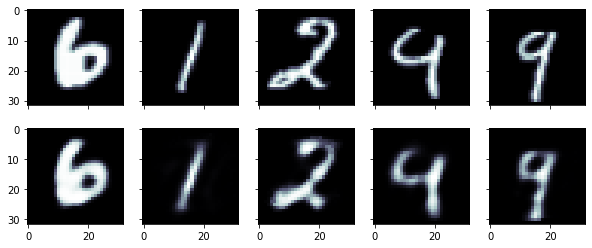

In [ ]:
display_results(5)

## Autoencoder 2
compresses 32x32-pixel images with convolutional layers & restores the original images

In [ ]:
class AE2(tnn.Module):
    def __init__(self):        
        super(AE2,self).__init__()
        # encoder
        self.conv1=tnn.Conv2d(in_channels=1,out_channels=8,
                              kernel_size=(3,3),stride=(1,1),
                              padding=1)
        self.pool1=tnn.MaxPool2d(kernel_size=(2,2),
                                 stride=(2,2),padding=0)                                       
        self.conv2=tnn.Conv2d(in_channels=8,out_channels=24,
                              kernel_size=(3,3),stride=(1,1),
                              padding=1)                                         
        self.pool2=tnn.MaxPool2d(kernel_size=(2,2),
                                 stride=(2,2),padding=0)
        # decoder
        self.conv3=tnn.Conv2d(in_channels=24,out_channels=8,
                              kernel_size=(3,3),stride=(1,1),
                              padding=1)
        self.conv4=tnn.Conv2d(in_channels=8,out_channels=1,
                              kernel_size=(3,3),stride=(1,1),
                              padding=1)       
    def forward(self,x):        
        # encoder
        x=self.conv1(x); x=tnnf.leaky_relu(x)
        x=self.pool1(x)
        x=self.conv2(x); x=tnnf.leaky_relu(x)
        x=self.pool2(x)        
        # decoder
        x=tnnf.interpolate(x,scale_factor=2,mode='nearest')
        x=self.conv3(x)
        x=tnnf.leaky_relu(x)
        x=tnnf.interpolate(x,scale_factor=2,mode='nearest')
        x=self.conv4(x)
        logits=tnnf.leaky_relu(x)
        probs=torch.sigmoid(logits)
        return logits,probs

## Training

In [ ]:
torch.manual_seed(random_seed)
learning_rate=.05
model=AE2()
model=model.to(dev)
optimizer2=torch.optim.Adam(model.parameters(),
                            lr=learning_rate)

In [ ]:
epochs=100
for epoch in range(epochs):
    for batch_ids,(features,targets) in enumerate(train_loader2):
        features=features.to(dev)
        logits,decoded=model(features)
        cost=tnnf.binary_cross_entropy_with_logits(logits,features)
        optimizer2.zero_grad()      
        cost.backward(); optimizer2.step()
        if not batch_ids%100:
            print ('Epoch: %03d/%03d | Batch: %03d/%03d | Cost: %.4f' 
                   %(epoch+1,epochs,batch_ids,
                     len(train_loader2),cost))

Epoch: 001/100 | Batch: 000/089 | Cost: 0.6931
Epoch: 002/100 | Batch: 000/089 | Cost: 0.6504
Epoch: 003/100 | Batch: 000/089 | Cost: 0.7559
Epoch: 004/100 | Batch: 000/089 | Cost: 0.6648
Epoch: 005/100 | Batch: 000/089 | Cost: 0.6485
Epoch: 006/100 | Batch: 000/089 | Cost: 0.6462
Epoch: 007/100 | Batch: 000/089 | Cost: 0.6415
Epoch: 008/100 | Batch: 000/089 | Cost: 0.6417
Epoch: 009/100 | Batch: 000/089 | Cost: 0.6444
Epoch: 010/100 | Batch: 000/089 | Cost: 0.6372
Epoch: 011/100 | Batch: 000/089 | Cost: 0.6442
Epoch: 012/100 | Batch: 000/089 | Cost: 0.6393
Epoch: 013/100 | Batch: 000/089 | Cost: 0.6372
Epoch: 014/100 | Batch: 000/089 | Cost: 0.6419
Epoch: 015/100 | Batch: 000/089 | Cost: 0.6492
Epoch: 016/100 | Batch: 000/089 | Cost: 0.6438
Epoch: 017/100 | Batch: 000/089 | Cost: 0.6444
Epoch: 018/100 | Batch: 000/089 | Cost: 0.6335
Epoch: 019/100 | Batch: 000/089 | Cost: 0.6450
Epoch: 020/100 | Batch: 000/089 | Cost: 0.6421
Epoch: 021/100 | Batch: 000/089 | Cost: 0.6464
Epoch: 022/10

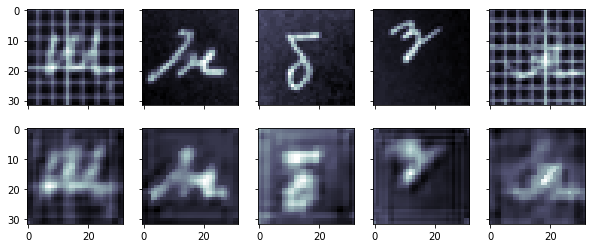

In [ ]:
display_results(5)